First, we'll obtain the single-peak Gaussian signals that we randomly generated. This will be the simplest test case for this RNN method, and we'll build the complexity from here.

In [272]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np

In [273]:
# try making Gauss peaks more narrow

In [274]:
# path = 'saved_data/math_functions_single.nc'
path = 'saved_data/math_functions_single_narrow_noisy.nc'

# Load .nc file
ds = xr.open_dataset(path)

gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
print(type(binary))
for j in range(binary.shape[0]):
    idx = np.where(binary[j] == 1)[0][0] # because there's only 1 "1" we can use [0][0]
    binary[j][idx - 2] = 1
    binary[j][idx - 1] = 1
    binary[j][idx + 1] = 1
    binary[j][idx + 2] = 1

x = ds["x"].values

<class 'numpy.ndarray'>


In [275]:
binary.shape

(10000, 500)

Visualize some of the randomly generated Gaussian signals with single peaks.

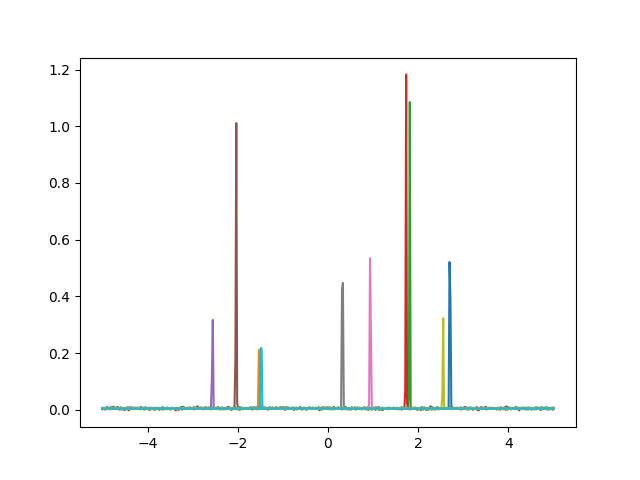

In [276]:
plt.figure()

for i in range(10):
    plt.plot(x, gaussians[i])

# adding noise: Dan says to add it to improve perfromance
# any weight in NN times 0 is 0. ideally what this is learning is a series of weights with behavior you want
# problem with 0 is that it's so sharp that those weights don't behave
# noise level of 0.05 or smth poisson distribution

In [277]:
import torch
import torch.nn as nn

In [278]:
sequence_length = 500 # num of x values
input_size = 2 # 2 because we have (x, intensity) coordinates, which are 2 features

# input shape should be: (batch_size, sequence_length, input_size)
batch_size = 32 # can make batch size = 5?

In [279]:
i = 1 
peak_idx = gaussians[i].argmax()
peak_x = x[peak_idx]

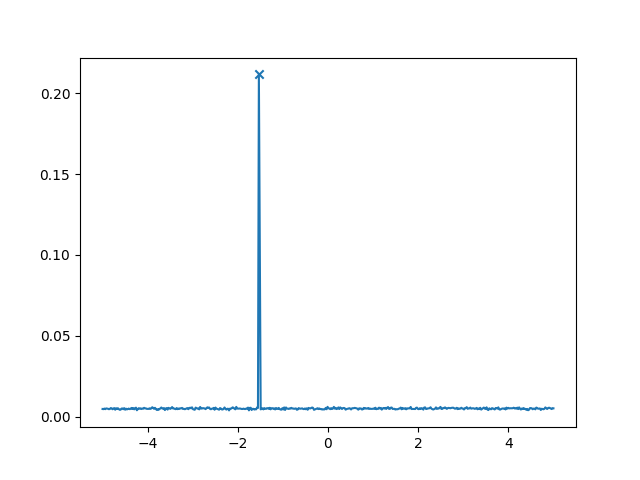

In [280]:
peak_idx
plt.figure()
plt.scatter(peak_x, gaussians[i][peak_idx], marker='x')
plt.plot(x, gaussians[i])

In [281]:
import torch.optim as optim

In [282]:
total_num = gaussians.shape[0]

all_x_arrs = []
for _ in range(total_num):
    all_x_arrs.append(x)

all_xs = np.stack(all_x_arrs, axis=0)
all_xs.shape

(10000, 500)

In [283]:
# data shape: (batch_size, sequence_length, input_size)
# make data tensor
# ()
print(all_xs.shape)
print(gaussians.shape)

(10000, 500)
(10000, 500)


In [284]:
gaussians[0]

array([0.00385245, 0.00532913, 0.00528799, 0.00604293, 0.00440049,
       0.00445798, 0.00441029, 0.00404627, 0.00230364, 0.00598086,
       0.00584264, 0.00342724, 0.00455822, 0.00423378, 0.00427409,
       0.00279174, 0.00435033, 0.00561689, 0.00764159, 0.00540688,
       0.00512614, 0.00446803, 0.00438049, 0.00597783, 0.00530037,
       0.00434405, 0.00394568, 0.00483306, 0.00444923, 0.00499429,
       0.00476319, 0.00540184, 0.0036943 , 0.00612702, 0.00786744,
       0.00623193, 0.00522565, 0.00591005, 0.00395854, 0.00336592,
       0.00579852, 0.0044446 , 0.00361012, 0.00409116, 0.00383318,
       0.00513874, 0.0056008 , 0.00591623, 0.00592302, 0.00577922,
       0.00478619, 0.00435652, 0.00344347, 0.00613492, 0.00481657,
       0.00457645, 0.00621756, 0.00407298, 0.00586157, 0.00530607,
       0.00392888, 0.00492176, 0.00600418, 0.00582112, 0.00654341,
       0.00534903, 0.00848048, 0.00405008, 0.00458857, 0.00493718,
       0.00353574, 0.00607593, 0.00593252, 0.00501961, 0.00444

In [285]:
from torch.utils.data import DataLoader, TensorDataset

In [286]:
all_data = torch.from_numpy(np.stack((all_xs, gaussians), axis=-1).astype(np.float32)) # shape = (1000, 500, 2)
binary = torch.from_numpy(binary)
print(all_data.shape)
print(binary.shape)

torch.Size([10000, 500, 2])
torch.Size([10000, 500])


In [287]:
from sklearn.model_selection import train_test_split

tv_X, test_X, tv_y, test_y = train_test_split(all_data, binary, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(tv_X, tv_y, test_size = 0.25, shuffle=False)

In [288]:
train_X = train_X.float()
val_X = val_X.float()
test_X = test_X.float()

train_y = train_y.float()
val_y = val_y.float()
test_y = test_y.float()

In [289]:
train_ds = TensorDataset(train_X, train_y)
val_ds = TensorDataset(val_X, val_y)
test_ds = TensorDataset(test_X, test_y)

In [290]:
train_ds.tensors

(tensor([[[-5.0000e+00,  3.8525e-03],
          [-4.9800e+00,  5.3291e-03],
          [-4.9599e+00,  5.2880e-03],
          ...,
          [ 4.9599e+00,  5.1315e-03],
          [ 4.9800e+00,  4.6270e-03],
          [ 5.0000e+00,  4.7539e-03]],
 
         [[-5.0000e+00,  4.7558e-03],
          [-4.9800e+00,  4.6438e-03],
          [-4.9599e+00,  5.0200e-03],
          ...,
          [ 4.9599e+00,  4.7333e-03],
          [ 4.9800e+00,  5.2878e-03],
          [ 5.0000e+00,  5.1622e-03]],
 
         [[-5.0000e+00,  5.2471e-03],
          [-4.9800e+00,  7.0495e-03],
          [-4.9599e+00,  4.5730e-03],
          ...,
          [ 4.9599e+00,  7.8310e-03],
          [ 4.9800e+00,  7.4071e-03],
          [ 5.0000e+00,  3.5995e-03]],
 
         ...,
 
         [[-5.0000e+00,  5.7089e-03],
          [-4.9800e+00,  1.6534e-03],
          [-4.9599e+00,  2.5467e-03],
          ...,
          [ 4.9599e+00,  9.1026e-03],
          [ 4.9800e+00,  8.4910e-04],
          [ 5.0000e+00,  4.9844e-03]],
 


In [291]:
# sequence_length = gaussians.shape[1]

# idx_1 = int(total_num*0.6)
# idx_2 = int(total_num*0.8)

# train_x = torch.from_numpy(all_xs[0 : idx_1])
# train_gauss = torch.from_numpy(gaussians[0 : idx_1])

# val_x = torch.from_numpy(all_xs[idx_1 : idx_2])
# val_gauss = torch.from_numpy(gaussians[idx_1 : idx_2])

# test_x = torch.from_numpy(all_xs[idx_2 : ])
# test_gauss = torch.from_numpy(gaussians[idx_2 : ])

In [292]:
# print(train_x.shape)
# print(val_x.shape)
# print(test_x.shape)

# print(train_x.shape)
# print(val_x.shape)
# print(test_x.shape)

In [293]:
# train_x = train_x.float()
# val_x = val_x.float()
# test_x = test_x.float()

In [294]:
# train_gauss = train_gauss.float()
# val_gauss = val_gauss.float()
# test_gauss = test_gauss.float()

In [295]:
# train_ds = TensorDataset(train_x, train_gauss)
# val_ds = TensorDataset(val_x, val_gauss)
# test_ds = TensorDataset(test_x, test_gauss)

In [296]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [297]:
class PeakFinderRNN(nn.Module):
    # maybe should make input size 2? idk ...
    def __init__(self, input_size=input_size, hidden_size=64, num_layers=1, output_size=1):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) # output_size=1 
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        logits = self.fc(rnn_out)  # Predict peak position
        return logits.squeeze(-1)  # shape: (batch,)

In [298]:
model = PeakFinderRNN()
pos_weight = torch.tensor([100.0])  # e.g., ratio of 1/0 samples
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [299]:
num_epochs = 10
train_loss = [] 
val_loss = []

for epoch in range(num_epochs):
    model.train() # train the model
    epoch_train_loss = 0.0 # record training loss for this epoch

    for x, y in train_loader:
        pred_y = model(x) # predict a label
        loss = criterion(pred_y, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Average the training loss over all batches
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    # all_preds = []
    # all_labels = []

    model.eval()
    epoch_val_loss = 0.0

    with torch.no_grad():
        for xval, yval in val_loader:
            logits = model(xval)  # raw output
            probs = torch.sigmoid(logits)  # convert logits to probabilities
            loss = criterion(logits, yval)

            epoch_val_loss += loss.item()
        
        # Average the validation loss over all batches
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

    
    # print(f'Epoch {epoch}/{num_epochs}. Train_loss = {train_loss:.4f} and val loss = {val_loss:.4f}')
    print(f'Epoch {epoch}/{num_epochs}')


Epoch 0/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10


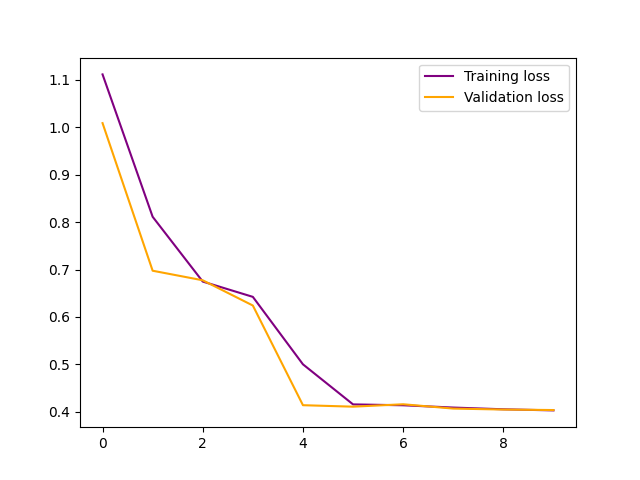

In [300]:
plt.close('all')
plt.figure()
plt.plot(np.arange(len(train_loss)), train_loss, color='purple', label='Training loss')
plt.plot(np.arange(len(val_loss)), val_loss, color='orange', label='Validation loss')
plt.legend()
plt.show()

In [301]:
# Test the model
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for xtest, ytest in test_loader:
        logits = model(xtest)
        loss = criterion(logits, ytest)
        test_loss += loss.item()

        probs = torch.sigmoid(logits)
        all_preds.append(probs)
        all_labels.append(ytest)

avg_test_loss = test_loss / len(test_loader)
print(avg_test_loss)

0.4053050076204633


In [302]:
all_labels_2 = torch.cat(all_labels).cpu().numpy()
all_preds_2 = torch.cat(all_preds).cpu().numpy()

In [303]:
plt.close('all')

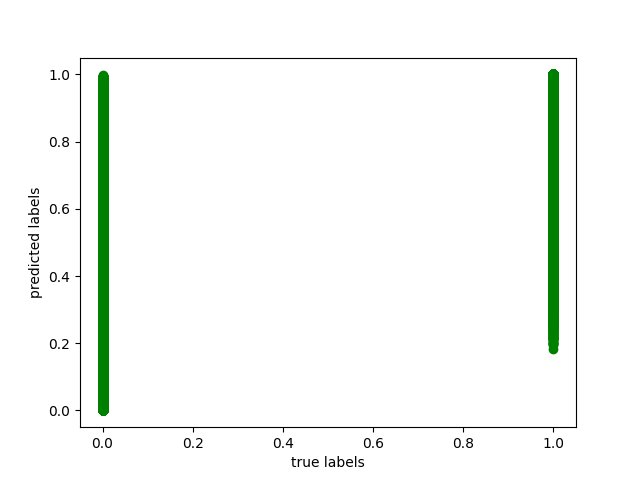

In [304]:
plt.figure()
plt.scatter(all_labels_2, all_preds_2, color='green')
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()

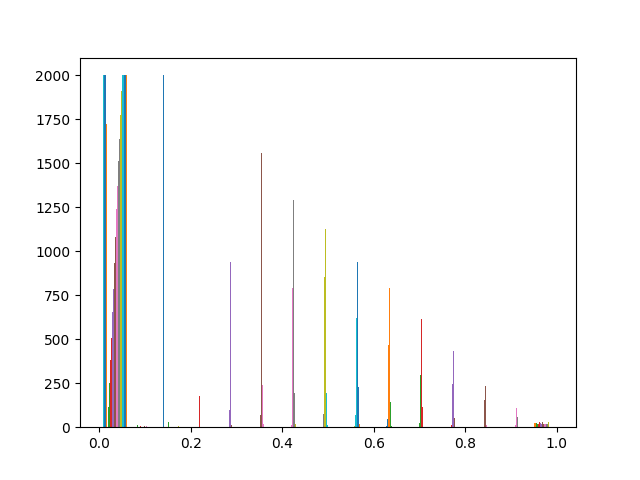

In [305]:
# visualize the distribution better
plt.figure()
plt.hist(all_preds_2, bins=15)
plt.show()

In [306]:
rounded_labels_pred = np.round(all_preds_2)
print(rounded_labels_pred.shape)

(2000, 500)


In [307]:
rounded_labels_true = np.round(all_labels_2)


In [308]:
all_0 = []
all_1 = []
all_1_idx_pred = []

In [309]:
for j in range(rounded_labels_pred.shape[0]):
    count_0 = 0
    count_1 = 0
    for i in rounded_labels_pred[j]:
        if int(i) == 0: count_0 += 1
        if int(i) == 1:
            count_1 += 1
    

    all_0.append(count_0)
    all_1.append(count_1)

print(all_0)
print(all_1)
print(all_1_idx_pred)

[497, 495, 461, 497, 445, 354, 463, 293, 496, 321, 496, 428, 340, 495, 435, 496, 412, 434, 428, 371, 464, 422, 497, 319, 360, 412, 321, 369, 412, 328, 297, 324, 496, 496, 496, 469, 384, 497, 470, 496, 459, 393, 349, 497, 408, 496, 312, 370, 497, 496, 370, 420, 496, 466, 489, 430, 483, 496, 407, 496, 472, 320, 497, 390, 487, 340, 444, 470, 496, 370, 497, 496, 355, 361, 497, 383, 385, 344, 453, 496, 496, 322, 402, 497, 435, 445, 380, 464, 496, 350, 335, 292, 446, 338, 494, 497, 322, 345, 326, 391, 497, 376, 496, 468, 309, 343, 496, 497, 356, 487, 412, 414, 496, 299, 496, 450, 322, 311, 495, 440, 473, 376, 371, 496, 496, 465, 344, 369, 497, 435, 470, 496, 494, 496, 471, 496, 496, 435, 402, 496, 299, 496, 397, 496, 496, 377, 493, 497, 471, 345, 496, 357, 327, 451, 496, 416, 497, 496, 496, 428, 400, 312, 496, 474, 430, 496, 496, 497, 494, 295, 376, 473, 343, 448, 469, 476, 456, 353, 383, 496, 496, 497, 405, 377, 306, 341, 297, 497, 397, 390, 292, 497, 384, 484, 399, 469, 416, 397, 496, 496,

In [310]:
x_vals = ds['x'].values

predicted: [-1.57314629 -1.55310621 -1.53306613]
true: [-1.61322645 -1.59318637 -1.57314629 -1.55310621 -1.53306613]
predicted: [-1.49298597 -1.47294589 -1.45290581 -1.43286573 -1.41282565]
true: [-1.51302605 -1.49298597 -1.47294589 -1.45290581 -1.43286573]
predicted: [-1.21242485 -1.19238477 -1.17234469 -1.15230461 -1.03206413 -1.01202405
 -0.99198397 -0.97194389 -0.95190381 -0.93186373 -0.91182365 -0.89178357
 -0.87174349 -0.85170341 -0.83166333 -0.81162325 -0.79158317 -0.77154309
 -0.75150301 -0.73146293 -0.71142285 -0.69138277 -0.67134269 -0.65130261
 -0.63126253 -0.61122244 -0.59118236 -0.57114228 -0.5511022  -0.53106212
 -0.51102204 -0.49098196 -0.47094188 -0.4509018  -0.43086172 -0.41082164
 -0.39078156 -0.37074148 -0.3507014 ]
true: [-0.4509018  -0.43086172 -0.41082164 -0.39078156 -0.37074148]


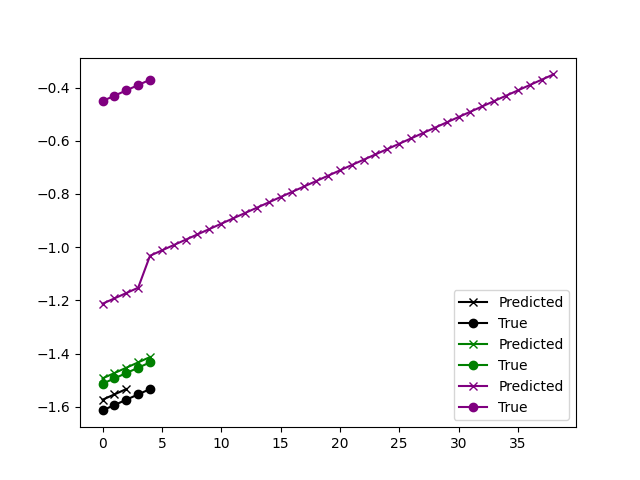

In [311]:
plt.figure()
colors = ['black', 'green', 'purple']

# Visualize how far the predicted peaks are from the real peaks

for sample_idx in range(3):
    pred_idx = np.where(rounded_labels_pred[sample_idx] == 1)[0]
    true_idx = np.where(rounded_labels_true[sample_idx] == 1)[0]

    print(f'predicted: {x_vals[pred_idx]}')
    print(f'true: {x_vals[true_idx]}')

    plt.plot(x_vals[pred_idx], marker='x', label='Predicted', color=colors[sample_idx])
    plt.plot(x_vals[true_idx], marker='o', label='True', color=colors[sample_idx])

plt.legend()
plt.show()